In [1]:
#import os
#os.environ["CUDA_VISIBLE_DEVICES"]="0"#"2"
#!pip install joypy
#!pip uninstall DeeR
#!pip install DeeR
!pip install DeeR --upgrade

You should consider upgrading via the 'c:\users\natha\anaconda3\python.exe -m pip install --upgrade pip' command.


In [2]:
# import estimator class
from estimators.rnnEstimator import RnnEstimator
from estimators.kalmanEstimator import KalmanEstimator
from estimators.particleFilterEstimator import ParticleFilterEstimator

#import rewarder class
from rewarders.thresholdRewarder import ThresholdRewarder

from matplotlib import pyplot
from utils.sequences_treatment import *
from utils.agent_treatment import *
from utils.plots import *

# import functions from Keras for the RNN
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, SimpleRNN#, Dropout, Embedding, Masking, Bidirectional
from keras.optimizers import Adam

In [3]:
# Set parameters
estimatorType='particle' # kalman or rnn
seeAction=True
seeMeasurement=True
seeEstimate=False
seeTime=False
T=12

In [4]:
if estimatorType=='rnn':
    # construct and train a Sequential RNN model with keras
    numberSamples_trainRNN=500
    T_trainRNN=T
    generatorType='random01'

    # generate sequences for training
    (objectives_trainRNN,measurements_trainRNN)=generateSequence(T_trainRNN,numberSamples=numberSamples_trainRNN,generatorType=generatorType)
    sigmas_trainRNN=randomSigma(T_trainRNN,numberSamples=numberSamples_trainRNN,p0=0.2)
    measurements_corrupted_trainRNN=corruptSequence_outOfRange(measurements_trainRNN,sigmas_trainRNN)

    n_dim_meas=np.shape(measurements_corrupted_trainRNN)[2]
    n_dim_obj=np.shape(objectives_trainRNN)[2]

    model=Sequential()
    model.add(LSTM(20,input_shape=(None,n_dim_meas),return_sequences=True))
    model.add(LSTM(20,return_sequences=True))
    model.add(Dense(n_dim_obj,activation=None))

    model.compile(optimizer='adam',loss='mean_squared_error')
    model.summary()

    # train the RNN
    history=model.fit(x=measurements_corrupted_trainRNN,y=objectives_trainRNN,batch_size=1,epochs=20,validation_split=0.2,verbose=2)

    # plot loss
    plotRNNresults(history)
print('Done')

Done


In [5]:
if estimatorType=='rnn':
    idx_sample=2
    estimates_trainRNN=model.predict(measurements_corrupted_trainRNN)
    plotExperiment(objectives_trainRNN, estimates_trainRNN, sigmas_trainRNN,idx_sample=idx_sample)
print('Done')

Done


In [6]:
# construct estimator
if estimatorType=='rnn':
    estimator=RnnEstimator(model,generatorType,seeAction=seeAction,seeMeasurement=seeMeasurement,seeEstimate=seeEstimate,seeTime=seeTime)
elif estimatorType=='kalman':
    estimator=KalmanEstimator(seeAction=seeAction,seeMeasurement=seeMeasurement,seeEstimate=seeEstimate,seeTime=seeTime)
elif estimatorType == 'particle':
    estimator = ParticleFilterEstimator(seeAction=seeAction,seeMeasurement=seeMeasurement,seeEstimate=seeEstimate,seeTime=seeTime)
else:
    print('ERROR: no valid estimatorType')
    
estimator.summarize()
print()

# contruct rewarder
rewarder=ThresholdRewarder(threshold=2, cost=10000, windowSize=4)
rewarder.summarize()

Particle filter estimator
  observationsDimensions: [(5,), (5, 1)]
  seeAction= True
  seeMeasurement= True
  seeEstimate= False
  seeTime= False

Threshold rewarder
  window size: 4
  threshold: 2
  cost: 10000
  number of measures in the window: 0


In [7]:
# generate sequences for training and validating the agent
numberSamples_train=100
T_train=T

numberSamples_valid=numberSamples_train
T_valid=T_train

(objectives_train,measurements_train)=estimator.generateSequence(T_train,numberSamples=numberSamples_train)
(objectives_valid,measurements_valid)=estimator.generateSequence(T_valid,numberSamples=numberSamples_valid)

print('shape training objectives:',np.shape(objectives_train))
print('shape training measurements:',np.shape(measurements_train))
print('shape validating objectives:',np.shape(objectives_valid))
print('shape validating measurements:',np.shape(measurements_valid))

shape training objectives: (100, 12, 1)
shape training measurements: (100, 12, 1)
shape validating objectives: (100, 12, 1)
shape validating measurements: (100, 12, 1)


In [8]:
# construct agent
agent=constructAgent(estimator,rewarder,objectives_train,measurements_train,objectives_valid,measurements_valid)
print('Agent constructed')

Environment parameters
  inputDimensions= [(5,), (5, 1)]
Sequences parameters
  outOfRangeValue= -1
  n_dim_obj= 1
  n_dim_meas= 1
  numberSamples_train 100
  numberSamples_valid 100
Particle filter estimator
  observationsDimensions: [(5,), (5, 1)]
  seeAction= True
  seeMeasurement= True
  seeEstimate= False
  seeTime= False
Threshold rewarder
  window size: 4
  threshold: 2
  cost: 10000
  number of measures in the window: 0
Agent constructed


In [9]:
# Train agent
agent.resumeTrainingMode() # not required
agent.run(n_epochs=10, epoch_length=numberSamples_train*T_train)
cumulatedRewards_valid=agent._controllers[2].rewards
print('Agent Trained')

Average (on the epoch) training loss: 49.18282943220522
Episode average V value: -2.5319607257843018


C:\Users\natha\OneDrive\UCL\Passerelle\TFE\github\optiMeasRL\utils\pfilter.py:364: RuntimeWarning: divide by zero encountered in log
  self.weight_entropy = np.sum(self.weights * np.log(self.weights))
C:\Users\natha\OneDrive\UCL\Passerelle\TFE\github\optiMeasRL\utils\pfilter.py:364: RuntimeWarning: invalid value encountered in multiply
  self.weight_entropy = np.sum(self.weights * np.log(self.weights))


Average (on the epoch) training loss: 2718.4270543604694
Episode average V value: -39.5893746415774
Average (on the epoch) training loss: 3094.505721679801
Episode average V value: -88.10045623779297
Average (on the epoch) training loss: 2982.0315542170356
Episode average V value: -306.42697016398114
Average (on the epoch) training loss: 2781.864999137569
Episode average V value: -708.4264526367188
Average (on the epoch) training loss: 2600.398741721792
Episode average V value: -774.6912897283381
Average (on the epoch) training loss: 2439.782386116922
Episode average V value: -992.952392578125
Average (on the epoch) training loss: 2287.237830247668
Episode average V value: -343.70526123046875
Average (on the epoch) training loss: 2170.6120500357047
Episode average V value: -297.0407409667969
Average (on the epoch) training loss: 2052.4290232008934
Episode average V value: -185.4338722229004
Average (on the epoch) training loss: 1938.1725564375104
Episode average V value: -115.446969985

Average (on the epoch) training loss: 737.8130061929418
Episode average V value: -132.36534269650778
Average (on the epoch) training loss: 738.0195946269466
Episode average V value: -388.7072448730469
Average (on the epoch) training loss: 739.9322051877438
Episode average V value: -183.59632301330566
Average (on the epoch) training loss: 739.8105461799876
Episode average V value: -182.67596435546875
Average (on the epoch) training loss: 739.1233245422488
Episode average V value: -208.58410835266113
Average (on the epoch) training loss: 739.8879565546076
Episode average V value: -108.47802734375
Average (on the epoch) training loss: 739.7646163776328
Episode average V value: -132.49481201171875
Average (on the epoch) training loss: 739.2649754801266
Episode average V value: -169.39075247446695
Average (on the epoch) training loss: 739.8725700948817
Episode average V value: -155.23536682128906
Average (on the epoch) training loss: 738.5541644033838
Episode average V value: -156.429565429

Average (on the epoch) training loss: 419.02282216922123
Episode average V value: -140.78589884440103
Average (on the epoch) training loss: 418.02989597041653
Episode average V value: -215.59303283691406
Average (on the epoch) training loss: 416.8289317911372
Episode average V value: -215.9818115234375
Average (on the epoch) training loss: 416.53400280652954
Episode average V value: -160.6640764872233
Average (on the epoch) training loss: 414.06101170462284
Episode average V value: -214.84880193074545
Average (on the epoch) training loss: 416.46600064202175
Episode average V value: -266.3712158203125
Average (on the epoch) training loss: 414.73416949635435
Episode average V value: -233.96929931640625
Average (on the epoch) training loss: 413.23735291913397
Episode average V value: -247.93251037597656
Average (on the epoch) training loss: 413.31119167114747
Episode average V value: -241.18121337890625
Average (on the epoch) training loss: 412.6610690802671
Episode average V value: -232.

Average (on the epoch) training loss: 374.0014977294482
Episode average V value: -170.32314809163412
Average (on the epoch) training loss: 372.3951021600955
Episode average V value: -197.3210881551107
Average (on the epoch) training loss: 372.09767766838945
Episode average V value: -230.7966505686442
Average (on the epoch) training loss: 376.79597650912586
Episode average V value: -214.04078674316406
Average (on the epoch) training loss: 372.55821247278107
Episode average V value: -255.33071899414062
Average (on the epoch) training loss: 369.88677466594424
Episode average V value: -166.3756866455078
Average (on the epoch) training loss: 370.0290473280839
Episode average V value: -283.4477373758952
Average (on the epoch) training loss: 368.3038338081869
Episode average V value: -235.21733856201172
Average (on the epoch) training loss: 368.94649292817326
Episode average V value: -171.8185577392578
Average (on the epoch) training loss: 370.6953539311661
Episode average V value: -190.73337

Average (on the epoch) training loss: 303.03817173083087
Episode average V value: -222.57807604471842
Average (on the epoch) training loss: 298.80117969021154
Episode average V value: -208.91780471801758
Average (on the epoch) training loss: 296.6898948007594
Episode average V value: -310.5553283691406
Average (on the epoch) training loss: 296.067798908524
Episode average V value: -182.60899699818003
Average (on the epoch) training loss: 292.38500028309306
Episode average V value: -153.09094619750977
Average (on the epoch) training loss: 290.4085328902479
Episode average V value: -173.5907325744629
Average (on the epoch) training loss: 292.44143681904393
Episode average V value: -183.24398803710938
Average (on the epoch) training loss: 293.08856032132724
Episode average V value: -190.4572556813558
Average (on the epoch) training loss: 291.3329598740022
Episode average V value: -238.55372937520346
Average (on the epoch) training loss: 292.1631585181756
Episode average V value: -171.2423

Average (on the epoch) training loss: 330.8486425339183
Episode average V value: -252.9889373779297
Average (on the epoch) training loss: 336.20343966606407
Episode average V value: -196.59722073872885
Average (on the epoch) training loss: 336.7668962300226
Episode average V value: -190.74505615234375
Average (on the epoch) training loss: 341.1736580415276
Episode average V value: -235.62596130371094
Average (on the epoch) training loss: 345.6391233910371
Episode average V value: -149.50424055619672
Average (on the epoch) training loss: 338.2452165049549
Episode average V value: -278.4673156738281
Average (on the epoch) training loss: 353.84159227200854
Episode average V value: -185.64501953125
Average (on the epoch) training loss: 360.93878986390024
Episode average V value: -158.01909001668295
Average (on the epoch) training loss: 362.1667151969402
Episode average V value: -157.24685871601105
Average (on the epoch) training loss: 358.68441647178827
Episode average V value: -186.088577

Average (on the epoch) training loss: 327.83698684577644
Episode average V value: -125.1483383178711
Average (on the epoch) training loss: 326.3070123647407
Episode average V value: -152.68269001353872
Average (on the epoch) training loss: 326.01382393276435
Episode average V value: -182.82747522989908
Average (on the epoch) training loss: 325.28987309342943
Episode average V value: -180.32232983907065
Average (on the epoch) training loss: 325.4165430572403
Episode average V value: -208.9824136098226
Average (on the epoch) training loss: 324.4478325174754
Episode average V value: -183.82612768809
Average (on the epoch) training loss: 324.06804787393116
Episode average V value: -153.9173205693563
Average (on the epoch) training loss: 323.40280775737443
Episode average V value: -153.49838574727377
Average (on the epoch) training loss: 321.6942572280335
Episode average V value: -177.89470117742366
Average (on the epoch) training loss: 321.0961964022346
Episode average V value: -162.275362

Average (on the epoch) training loss: 298.68311778266536
Episode average V value: -158.88571166992188
Average (on the epoch) training loss: 298.101194251721
Episode average V value: -248.58974329630533
Average (on the epoch) training loss: 296.67487540875766
Episode average V value: -133.4369354248047
Average (on the epoch) training loss: 296.01769416457824
Episode average V value: -132.305401802063
Average (on the epoch) training loss: 296.44771028844934
Episode average V value: -114.84329466386275
Average (on the epoch) training loss: 294.5616885234096
Episode average V value: -149.58887434005737
Average (on the epoch) training loss: 294.5342005785286
Episode average V value: -176.094482421875
Average (on the epoch) training loss: 294.74911598802015
Episode average V value: -180.40651194254556
Average (on the epoch) training loss: 295.0099955644378
Episode average V value: -152.32147280375162
Average (on the epoch) training loss: 295.4917826719092
Episode average V value: -159.149963

Average (on the epoch) training loss: 270.0290056284266
Episode average V value: -187.23112678527832
Average (on the epoch) training loss: 270.6703557623312
Episode average V value: -148.5207608540853
Average (on the epoch) training loss: 272.35693570254017
Episode average V value: -116.4462288943204
Average (on the epoch) training loss: 271.9141841483576
Episode average V value: -252.54352537790933
Average (on the epoch) training loss: 272.1066901613869
Episode average V value: -191.3346405029297
Average (on the epoch) training loss: 270.08440220983823
Episode average V value: -127.1462631225586
Average (on the epoch) training loss: 269.1805521432051
Episode average V value: -165.8733673095703
Average (on the epoch) training loss: 271.96526938165357
Episode average V value: -140.59133911132812
Average (on the epoch) training loss: 271.3194803074487
Episode average V value: -124.66204420725505
Average (on the epoch) training loss: 270.44943880051954
Episode average V value: -127.197357

Average (on the epoch) training loss: 311.56080043807935
Episode average V value: -159.58937974409625
Average (on the epoch) training loss: 312.03969158023284
Episode average V value: -190.9140240351359
Average (on the epoch) training loss: 315.8765505354728
Episode average V value: -171.90033149719238
Average (on the epoch) training loss: 314.5071958825886
Episode average V value: -156.41033824284872
Average (on the epoch) training loss: 313.70483522662954
Episode average V value: -97.38384246826172
Average (on the epoch) training loss: 314.9308590918725
Episode average V value: -142.97930908203125
Average (on the epoch) training loss: 313.420494149092
Episode average V value: -165.8707275390625
Average (on the epoch) training loss: 313.9644526922794
Episode average V value: -217.2753143310547
Average (on the epoch) training loss: 316.47356610192304
Episode average V value: -164.62181091308594
Average (on the epoch) training loss: 315.03223473040566
Episode average V value: -160.93437

Average (on the epoch) training loss: 248.53232919976057
Episode average V value: -139.10296503702799
Average (on the epoch) training loss: 247.91914207492098
Episode average V value: -214.25498962402344
Average (on the epoch) training loss: 247.62866003160943
Episode average V value: -146.81045532226562
Average (on the epoch) training loss: 261.0561170751526
Episode average V value: -158.56593322753906
Average (on the epoch) training loss: 261.78860125201834
Episode average V value: -200.69964252818716
Average (on the epoch) training loss: 261.80436477290795
Episode average V value: -133.09940433502197
Average (on the epoch) training loss: 265.1236816249114
Episode average V value: -179.6516087849935
Average (on the epoch) training loss: 266.30501951658505
Episode average V value: -228.34720102945963
Average (on the epoch) training loss: 266.57741809764667
Episode average V value: -165.7545928955078
Average (on the epoch) training loss: 275.0550346172094
Episode average V value: -186.

Average (on the epoch) training loss: 282.0654316066329
Episode average V value: -151.39835611979166
Average (on the epoch) training loss: 281.87732050168836
Episode average V value: -136.81353352286598
Average (on the epoch) training loss: 280.6829488494526
Episode average V value: -159.26780573527017
Average (on the epoch) training loss: 281.0183747716144
Episode average V value: -279.0788860321045
Average (on the epoch) training loss: 281.35861489180775
Episode average V value: -163.44102923075357
Average (on the epoch) training loss: 280.66351203227094
Episode average V value: -196.06117248535156
Testing score per episode (id: 0) is -751.5055600289812 (average over 100 episode(s))
Average (on the epoch) training loss: 353.9702816282133
Episode average V value: -181.39122009277344
Average (on the epoch) training loss: 240.29537953083937
Episode average V value: -150.28418262799582
Average (on the epoch) training loss: 258.57294588476987
Episode average V value: -127.9480676651001
Av

Average (on the epoch) training loss: 254.619226826549
Episode average V value: -258.6777038574219
Average (on the epoch) training loss: 253.46565397406053
Episode average V value: -193.52610848166725
Average (on the epoch) training loss: 252.6916753109519
Episode average V value: -191.82977294921875
Average (on the epoch) training loss: 251.8851210811149
Episode average V value: -126.2603891546076
Average (on the epoch) training loss: 252.29361764521292
Episode average V value: -189.4814453125
Average (on the epoch) training loss: 251.88376437634153
Episode average V value: -164.50022888183594
Average (on the epoch) training loss: 252.94887798414516
Episode average V value: -222.397216796875
Average (on the epoch) training loss: 251.6613479233123
Episode average V value: -165.85833740234375
Average (on the epoch) training loss: 250.6034388827712
Episode average V value: -208.89204088846842
Average (on the epoch) training loss: 249.14630807029786
Episode average V value: -177.953594207

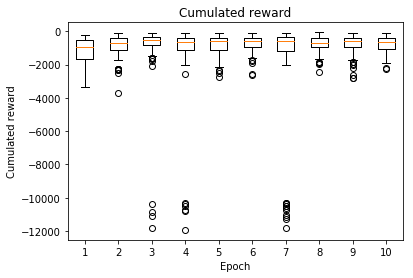

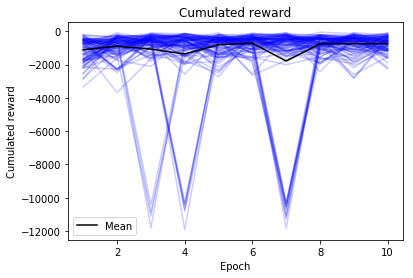

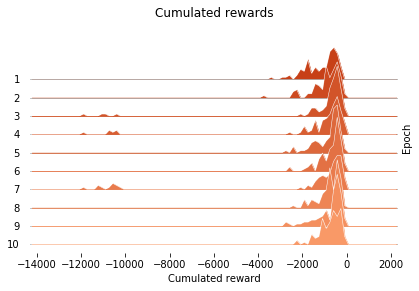

In [10]:
# plot validation
boxplotCumulatedRewards(cumulatedRewards_valid)
plotAllCumulatedRewards(cumulatedRewards_valid)
allHistoCumulatedRewards(cumulatedRewards_valid)

In [11]:
# generate test data
numberSamples_test=20
T_test=T
(objectives_test,measurements_test)=estimator.generateSequence(T_test,numberSamples=numberSamples_test)

# Results of the inference on test data
(sigmas_test,rewards_test,estimates_test)=agentInference(agent,objectives_test,measurements_test)
print('Test results computed')

Test results computed


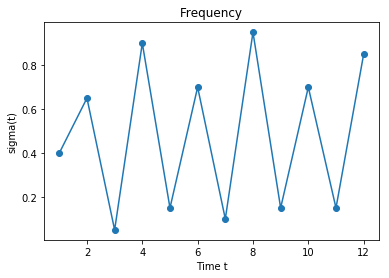

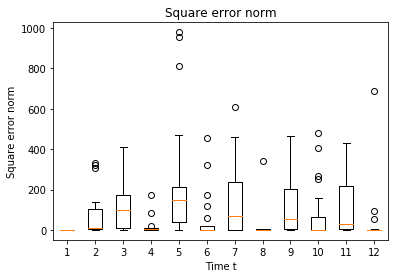

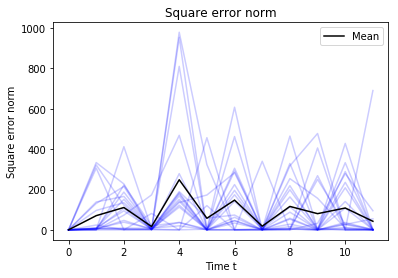

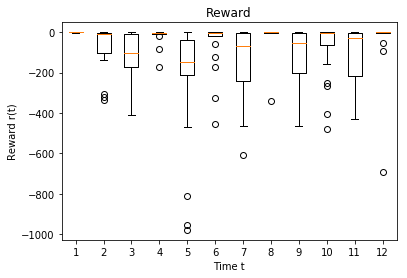

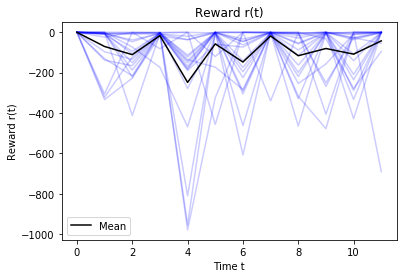

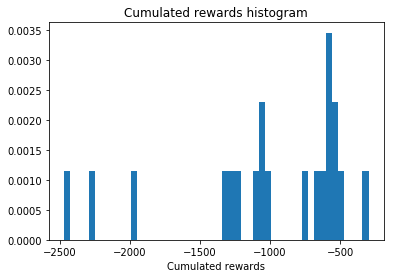

array([[1., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1.],
       [0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.],
       [0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.],
       [0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.],
       [1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1.],
       [0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.],
       [0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 1., 1.],
       [0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.],
       [1., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1.],
       [1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.],
       [0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 1., 1.],
       [0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.],
       [0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0.],
       [1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1.],
       [1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.],
       [0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.],
       [0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.],
       [0., 1., 0., 1., 0., 1.,

In [12]:
# plot test
idx_sample=5
#plotExperiment(objectives_test,estimates_test,sigmas_test,idx_sample=idx_sample)
freqSigmas(sigmas_test)
boxplotErrors(objectives_test,estimates_test)
plotAllErrors(objectives_test,estimates_test)
boxplotRewards(rewards_test)
plotAllRewards(rewards_test)
histoCumulatedRewards(rewards_test)
sigmas_test

In [13]:
# regular run on test data (default case without agent)
numberMeasurements=6

# compute regular sigma (with same dim than validation data)
sigmas_regular=regularSigma(T_valid,numberMeasurements,numberSamples=numberSamples_test)

(rewards_regular, estimates_regular)=agentForcedInference(agent, sigmas_regular)
print('Done.')

Done.


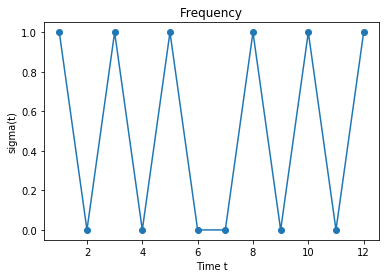

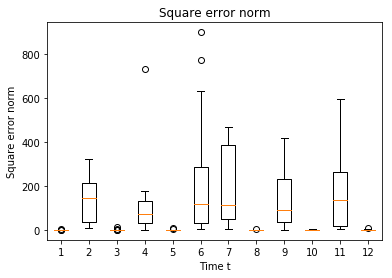

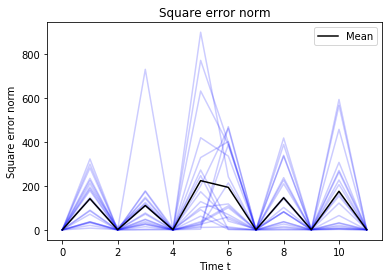

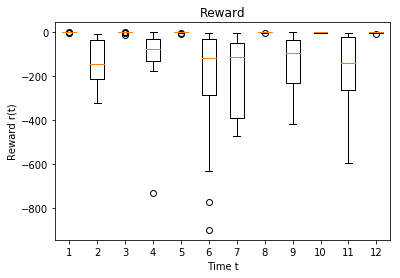

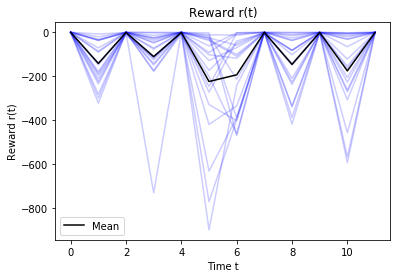

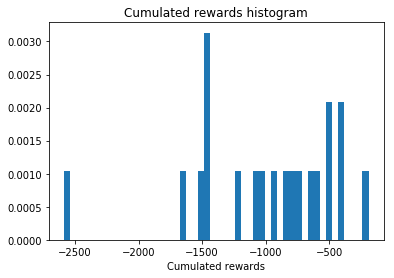

In [14]:
# plot test
idx_sample=5
#plotExperiment(objectives_test,estimates_test,sigmas_test,idx_sample=idx_sample)
freqSigmas(sigmas_regular)
boxplotErrors(objectives_test,estimates_regular)
plotAllErrors(objectives_test,estimates_regular)
boxplotRewards(rewards_regular)
plotAllRewards(rewards_regular)
histoCumulatedRewards(rewards_regular)

In [15]:
import importlib
import utils.agent_treatment
importlib.reload(utils.agent_treatment)
from utils.agent_treatment import *